# Evaluate Cross Validation on Simulated Data

In [122]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
import seaborn

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

In [182]:
def read_implant_positions(file):
    with open(file, 'r') as f:
        subnetworks = []
        disease_genes = []
        for subnet in f.readlines():
            if subnet.startswith('#'):
                continue
            vals = [int(i.strip()) for i in subnet.strip().split(':')[1].strip().split('\t')]
            subnetworks.append(vals)
            disease_genes.append(vals[0])
    return pd.DataFrame(subnetworks), disease_genes

def get_top_n_disease_genes(scores, disease_genes, n):
    return scores.head(n)[scores.head(n).index.isin(disease_genes)]

def get_disease_gene_scores(scores, disease_genes):
    return scores[scores.ID.isin(disease_genes)]

def get_recovered_nodes(scores, subnets):
    idx = []
    for score in scores.index:
        if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
            idx.append(score)
    return scores.loc[idx]

## Real Data

## Simulated Data

In [186]:
model_dir = '../data/GCN/training/2018_01_31_12_04_55/'
subnets, disease_genes = read_implant_positions('../data/simulation/implant_positions.txt')

# read predictions for each CV


In [187]:
# now that we have the predictions, see how many top ones they predict
all_preds = []
for p in predictions:
    recovered = get_disease_gene_scores(p, disease_genes)
    n_rec = recovered[recovered.Prob_pos > .5].shape[0]
    n_total = len(disease_genes)
    perc = n_rec / n_total
    print ("Recovered {}/{} disease genes ({}%)".format(n_rec, n_total, perc))
    all_preds += list(recovered[recovered > .5].index)
print ("------------------------------------------------")
print ("Predicted {} different disease genes in total".format(len(set(all_preds))))

# print number of genes predicted by all
all_nodes = list(predictions[0].index)
pos_preds = [list(p[p.Prob_pos >= .5].ID) for p in predictions]
print (len(set(all_nodes).intersection(*pos_preds)))
count = 1
for p in pos_preds:
    intersect = set(p).intersection(*pos_preds)
    print ("[Run {}] Overlap with all: ({} / {})".format(count, len(intersect), len(p)))
    count += 1
print ([len(p) for p in pos_preds])

Recovered 23/38 disease genes (0.6052631578947368%)
Recovered 23/38 disease genes (0.6052631578947368%)
Recovered 28/38 disease genes (0.7368421052631579%)
Recovered 29/38 disease genes (0.7631578947368421%)
Recovered 25/38 disease genes (0.6578947368421053%)
Recovered 23/38 disease genes (0.6052631578947368%)
Recovered 29/38 disease genes (0.7631578947368421%)
Recovered 24/38 disease genes (0.631578947368421%)
Recovered 27/38 disease genes (0.7105263157894737%)
Recovered 24/38 disease genes (0.631578947368421%)
------------------------------------------------
Predicted 38 different disease genes in total
32
[Run 1] Overlap with all: (32 / 52)
[Run 2] Overlap with all: (32 / 65)
[Run 3] Overlap with all: (32 / 111)
[Run 4] Overlap with all: (32 / 86)
[Run 5] Overlap with all: (32 / 107)
[Run 6] Overlap with all: (32 / 77)
[Run 7] Overlap with all: (32 / 86)
[Run 8] Overlap with all: (32 / 89)
[Run 9] Overlap with all: (32 / 125)
[Run 10] Overlap with all: (32 / 59)
[52, 65, 111, 86, 10

FileNotFoundError: [Errno 2] No such file or directory: '../data/GCN/training/2018_01_31_12_04_55/roc_curve.png'

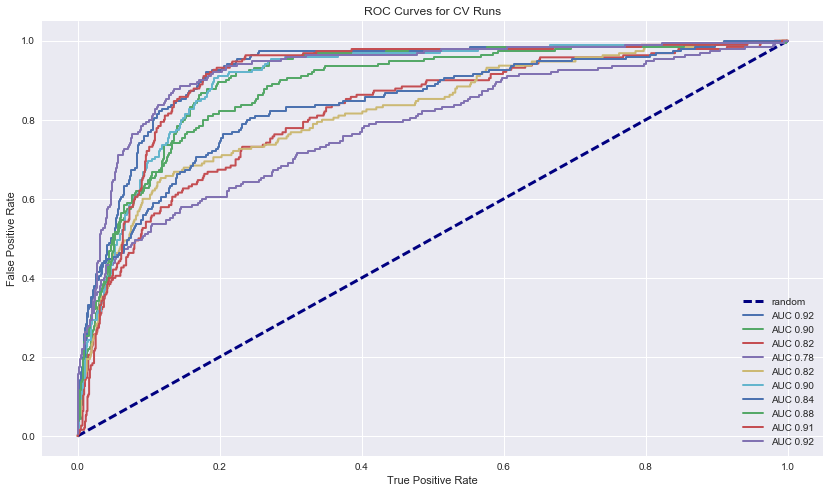

In [188]:
# plot roc for each run
all_aurocs = []
subnet_entries = subnets.values.flatten()
fig = plt.figure(figsize=(14, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='random')
for p in predictions:
    y_true = p.ID.isin(subnet_entries)
    y_score = p.Prob_pos
    tpr, fpr, _ = roc_curve(y_score=y_score, y_true=y_true)
    auc = roc_auc_score(y_score=y_score, y_true=y_true)
    all_aurocs.append(auc)
    plt.plot(tpr, fpr, lw=2, label='AUC {0:.2f}'.format(auc))
plt.legend()
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curves for CV Runs')
fig.savefig(os.path.join(model_dir, 'roc_curve.png'), dpi=300)
print (accuracy_score(y_true=y_true, y_pred=p.Prob_pos > 0.5))

FileNotFoundError: [Errno 2] No such file or directory: '../data/GCN/training/2018_01_31_12_04_55/prec_recall_curve.png'

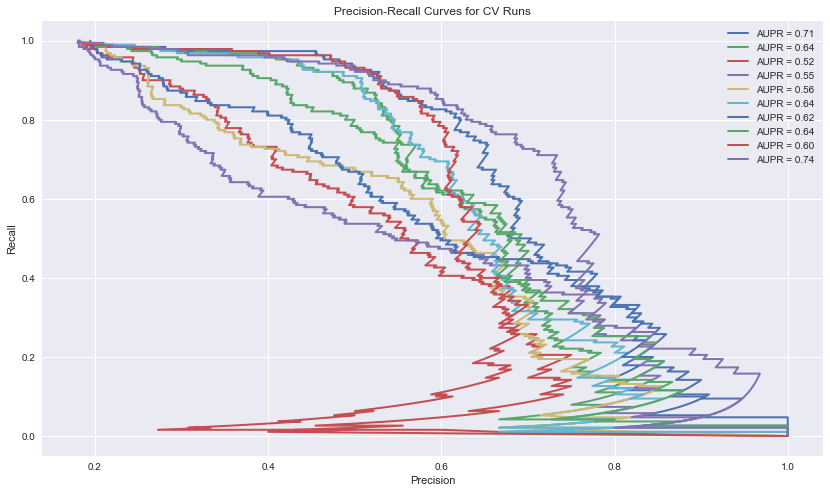

In [189]:
all_auprs = []
fig = plt.figure(figsize=(14, 8))
for p in predictions:
    y_true = p.ID.isin(subnet_entries)
    y_score = p.Prob_pos
    avg_prec = average_precision_score(y_true, y_score)
    all_auprs.append(avg_prec)
    pr, rc, _ = precision_recall_curve(y_true, y_score)
    plt.plot(pr, rc, lw=2, label='AUPR = {0:.2f}'.format(avg_prec))
plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curves for CV Runs')
fig.savefig(os.path.join(model_dir, 'prec_recall_curve.png'), dpi=300)

(10, 3)


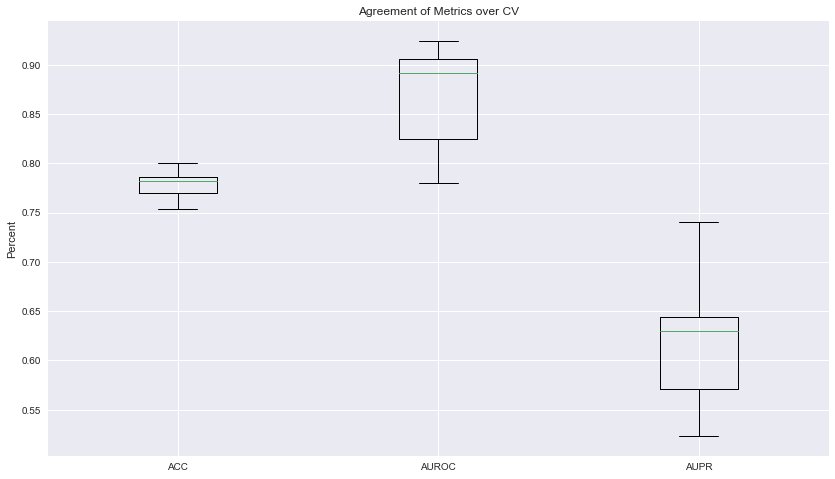

In [135]:
# all accuracies
all_accs = []
for p in predictions:
    y_true = p.index.isin(subnet_entries)
    y_pred = p.Prob_pos >= .5
    all_accs.append(accuracy_score(y_true=y_true, y_pred=y_pred))

# all number of predictions
all_n_preds = []
for p in predictions:
    all_n_preds.append(p[p.Prob_pos >= .5].shape[0])

# boxplot
fig = plt.figure(figsize=(14, 8))
all_metrics = np.vstack((all_accs, all_aurocs, all_auprs)).T
print (all_metrics.shape)
x = plt.boxplot(all_metrics)
plt.xticks([1, 2, 3], ['ACC', 'AUROC', 'AUPR'])
plt.ylabel('Percent')
plt.title('Agreement of Metrics over CV')
fig.savefig(os.path.join(model_dir, 'boxplot_agreement.png'))

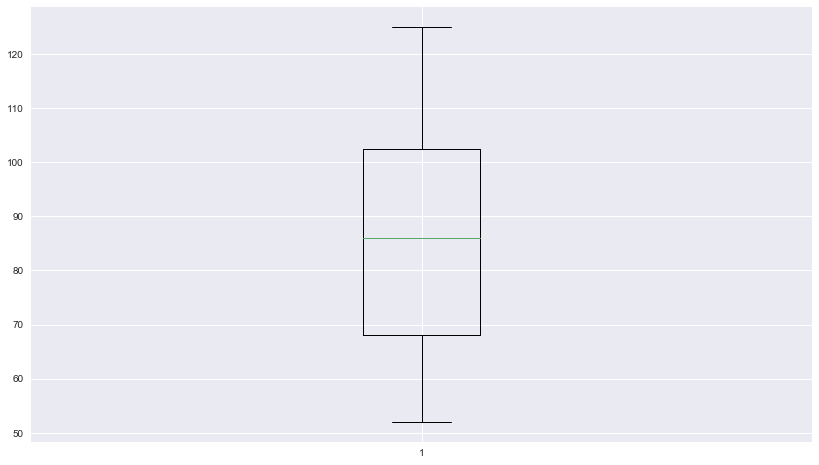

In [137]:
fig = plt.figure(figsize=(14, 8))
x = plt.boxplot(all_n_preds)